Use `sybil2` as the conda environment. 

In [366]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pandas as pd

In [367]:
def load_data(dir_name, file_prefix, type_):
    all_paths = [path for path in os.listdir(dir_name) if path.startswith(file_prefix) and path.endswith(".json")]

    print(dir_name)

    print(f"Processing {len(all_paths)} paths...")

    if type_ == "list":
        out = []
    elif type_ == "dict":
        out = {}

    for path in all_paths:
        with open(os.path.join(dir_name, path), 'r') as f:
            path_data = json.load(f)

            if type_ == "list":
                assert isinstance(path_data, list)
                out += path_data
            elif type_ == "dict":
                assert isinstance(path_data, dict)
                out |= path_data

    return out

In [368]:
def compute_annotation_stats(data):
    total_patients_with_annotations = 0
    total_scans_with_annotations = 0

    for patient_id, patient_data in data.items():
        bboxes = patient_data.get("bboxes", {})
        t0_has_bboxes = bboxes.get("T0_has_bboxes", False)
        t1_has_bboxes = bboxes.get("T1_has_bboxes", False)
        t2_has_bboxes = bboxes.get("T2_has_bboxes", False)
        
        if t0_has_bboxes or t1_has_bboxes or t2_has_bboxes:
            total_patients_with_annotations += 1
        
        total_scans_with_annotations += int(t0_has_bboxes) + int(t1_has_bboxes) + int(t2_has_bboxes)

    return total_patients_with_annotations, total_scans_with_annotations

In [369]:
def compute_basic_statistics(data, should_prune_t0=False, should_prune_unann=False):
    num_patients = len(data)
    scan_counts = [len(patient_data['total_num_nodules']) for patient_data in data.values()]
    
    num_scans = sum(scan_counts)
    num_patients_1_scan = sum(1 for c in scan_counts if c == 1)
    num_patients_2_scan = sum(1 for c in scan_counts if c == 2)
    num_patients_3_scan = sum(1 for c in scan_counts if c == 3)
    
    total_predicted_nodules = sum(
        sum(patient_data['total_num_nodules'].values()) for patient_data in data.values()
    )
    
    unmatched_nodules = sum(len(patient_data.get("unmatched_nodules", {})) for patient_data in data.values())
    matched_nodules_count = defaultdict(int)
    
    for patient_data in data.values():
        for nodule_id, timepoints in patient_data.get("matched_nodules", {}).items():
            assert len(timepoints) in {1, 2, 3}
            matched_nodules_count[len(timepoints)] += 1
    
    matched_nodules_2 = matched_nodules_count[2]
    matched_nodules_3 = matched_nodules_count[3]
    
    if not should_prune_t0 and not should_prune_unann:
        assert total_predicted_nodules == unmatched_nodules + 2 * matched_nodules_2 + 3 * matched_nodules_3

    num_patients_with_annotations, num_scans_with_annotations = compute_annotation_stats(data)
    
    return {
        "num_patients": num_patients,
        "num_patients_1_scan": num_patients_1_scan,
        "num_patients_2_scan": num_patients_2_scan,
        "num_patients_3_scan": num_patients_3_scan,
        "num_scans": num_scans,
        "total_predicted_nodules": total_predicted_nodules,
        "unmatched_nodules": unmatched_nodules,
        "matched_nodules_2": matched_nodules_2,
        "matched_nodules_3": matched_nodules_3,
        "num_patients_with_annotations": num_patients_with_annotations,
        "num_scans_with_annotations": num_scans_with_annotations,
    }

In [370]:
def compute_distributions(data, should_prune_t0=False):
    nodules_per_scan = []
    nodules_per_patient = []
    all_volumes = []
    matched_volumes = []
    
    for patient_id, patient_data in data.items():
        nodules_per_patient.append(sum(patient_data['total_num_nodules'].values()))
        
        for timepoint, count in patient_data['total_num_nodules'].items():
            nodules_per_scan.append(count)
        
        # matched
        for nodule in patient_data.get("matched_nodules", {}).values():
            for timepoint_data in nodule.values():
                all_volumes.append(timepoint_data["mask_volume"])
                matched_volumes.append(timepoint_data["mask_volume"])
        
        # unmatched
        for nodule in patient_data.get("unmatched_nodules", {}).values():
            all_volumes.append(nodule["mask_volume"])

    if not should_prune_t0:
        assert len(all_volumes) == sum(nodules_per_scan) and len(all_volumes) == sum(nodules_per_patient)
                
    return nodules_per_scan, nodules_per_patient, all_volumes, matched_volumes

In [371]:
def plot_distribution(data, title, xlabel, ylabel, with_mean=True, xlim=None, drop_vert_line=False):
    num_bins = 30
    size = 12
    print(data)
    plt.hist(data, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5)
    plt.title(f"{title} (N = {len(data)})", size=size)

    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data)
    
    if with_mean:
        text_str = f"Mean: {mean_val:.2f}\nMedian: {median_val:.2f}"
    else:
        text_str = f"Median: {median_val:.2f}"
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.xlabel(xlabel, size=size)
    plt.ylabel(ylabel, size=size)

    if drop_vert_line:
        plt.axvline(x=0, color='black', linestyle='dotted', linewidth=1)
        
    plt.show()

In [372]:
def plot_distribution_overlay(data1, data2, title, xlabel, ylabel, label1, label2, xlim=None):
    num_bins = 30
    size = 20
    plt.hist(data1, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5, color="blue", label=label1)
    plt.hist(data2, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5, color="red", label=label2)
    plt.title(f"{title} (N of {label1} = {len(data1)}, N of {label2} = {len(data2)})", size=size)

    # text_str = f"Median ({label1}): {np.median(data1):.2f}\nMedian ({label2}): {np.median(data2):.2f}"
    text_str = f"Median ({label1}): {np.median(data1):.2f}\nMedian ({label2}): {np.median(data2):.2f}\nMean ({label1}): {np.mean(data1):.2f}\nMean ({label2}): {np.mean(data2):.2f}"
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.xlabel(xlabel, size=size)
    plt.ylabel(ylabel, size=size)
    plt.legend()
    plt.show()

In [373]:
def prune_t0(data):
    out = {}

    for pid, pid_entry in data.items():
        out[pid] = {}
        out[pid]['matched_nodules'] = {
            k: v for k, v in pid_entry['matched_nodules'].items() if v.get('timepoint') != 'T0'
        }
        out[pid]['unmatched_nodules'] = {
            k: v for k, v in pid_entry['unmatched_nodules'].items() if v.get('timepoint') != 'T0'
        }
        out[pid]['bboxes'] = {k: v for k, v in pid_entry['bboxes'].items() if 'T0' not in k}
        out[pid]['reg_metrics'] = {k: v for k, v in pid_entry['reg_metrics'].items() if 'T0' not in k}

        out[pid]['total_num_voxels'] = {k: v for k, v in pid_entry['total_num_voxels'].items() if 'T0' not in k}
        out[pid]['total_num_nodules'] = {k: v for k, v in pid_entry['total_num_nodules'].items() if 'T0' not in k}

        if "T0" in pid_entry['total_num_voxels']:
            out[pid]['num_scans'] = pid_entry["num_scans"] - 1
        else:
            out[pid]['num_scans'] = pid_entry["num_scans"]

    return out
    

In [374]:
import re
from copy import deepcopy

def filter_patients_with_bboxes(all_patients):
    """
    Given a dict of patient entries, returns a new dict containing only those patients
    that have at least one bounding box (matched or unmatched), and with all summary
    fields updated to reflect only the preserved nodules.

    all_patients: {
        patient_id: {
            'matched_nodules': { nodule_id: {T0: {...}, T1: {...}, ...}, ... },
            'unmatched_nodules': { nodule_id: {..., 'timepoint': 'T0'}, ... },
            'bboxes': { 'T0_has_bboxes': bool, 'T1_has_bboxes': bool, ... },
            'reg_metrics': {...},
            'total_num_voxels': {'T0': int, 'T1': int, ...},
            'total_num_nodules': {'T0': int, 'T1': int, ...},
            'num_scans': int
        },
        ...
    }
    """
    out = {}
    timepoints = {"T0", "T1", "T2"}

    for pid, entry in all_patients.items():
        e = deepcopy(entry)

        # 1) filter matched_nodules: keep only those with any bbox_slice_range non-empty
        new_matched = {}
        for nid, ninfo in e['matched_nodules'].items():
            # check across all timepoints for this nodule
            has_box = any(
                (slice_list := ninfo.get(tp, {}).get('bbox_slice_range', []))
                for tp in timepoints
            )
            if has_box:
                # but prune out the empty‐bbox timepoints
                pruned = {
                    tp: sub
                    for tp, sub in ninfo.items()
                    if sub.get('bbox_slice_range')
                }
                new_matched[nid] = pruned

        # 2) filter unmatched_nodules: keep only those whose bbox_slice_range is non-empty
        new_unmatched = {}
        for nid, ninfo in e['unmatched_nodules'].items():
            if ninfo.get('bbox_slice_range'):
                new_unmatched[nid] = ninfo

        # if no bbox‐bearing nodules, skip this patient
        if not (new_matched or new_unmatched):
            continue

        # 3) recompute bboxes → “T*_has_bboxes”
        new_bboxes = {}
        for tp in sorted(timepoints):
            flag = any(
                tp in ninfo and ninfo[tp].get('bbox_slice_range')
                for ninfo in new_matched.values()
            ) or any(
                ninfo['timepoint'] == tp and ninfo.get('bbox_slice_range')
                for ninfo in new_unmatched.values()
            )
            new_bboxes[f"{tp}_has_bboxes"] = flag

        # 4) recompute total_num_nodules and total_num_voxels per TP
        new_tot_nod = {tp: 0 for tp in timepoints}
        new_tot_vox = {tp: 0 for tp in timepoints}

        # matched: count & sum for each TP where it survives
        for ninfo in new_matched.values():
            for tp, sub in ninfo.items():
                new_tot_nod[tp] += 1
                new_tot_vox[tp] += sub.get('mask_volume', 0)

        # unmatched: likewise
        for ninfo in new_unmatched.values():
            tp = ninfo['timepoint']
            new_tot_nod[tp] += 1
            new_tot_vox[tp] += ninfo.get('mask_volume', 0)

        # 5) recompute reg_metrics: any metric involving T_i & T_j gets zeroed unless both have bboxes
        new_reg = {}
        for k, v in e['reg_metrics'].items():
            # extract the two T’s from the key
            tps = re.findall(r'_for_(T\d)_.*_and_(T\d)', k)
            if tps:
                t0, t1 = tps[0]
                # keep only if both timepoints still have boxes
                if new_bboxes.get(f"{t0}_has_bboxes") and new_bboxes.get(f"{t1}_has_bboxes"):
                    new_reg[k] = v
                else:
                    new_reg[k] = None
            else:
                # if it doesn't follow that naming, keep as-is
                new_reg[k] = v

        # 6) num_scans = number of timepoints that still have bboxes
        new_num_scans = sum(new_bboxes.values())

        # assemble the filtered entry
        filtered = {
            **{k: v for k, v in e.items() if k not in (
                'matched_nodules', 'unmatched_nodules', 'bboxes',
                'reg_metrics', 'total_num_voxels', 'total_num_nodules', 'num_scans'
            )},
            'matched_nodules': new_matched,
            'unmatched_nodules': new_unmatched,
            'bboxes': new_bboxes,
            'reg_metrics': new_reg,
            'total_num_voxels': new_tot_vox,
            'total_num_nodules': new_tot_nod,
            'num_scans': new_num_scans
        }

        out[pid] = filtered

    return out


In [375]:
def filter_cancer_window_nodules_only(data, metadata):
    pid_subset = set()

    DAY_THRESH = 2 * 365 # two years

    for i, row in metadata.iterrows():
        if any([row[f"Days2Cancer_{tp}"] <= DAY_THRESH for tp in range(2)]):
            pid_subset.add(str(row["PID"]))

    return {pid: pid_entry for pid, pid_entry in data.items() if pid in pid_subset}

In [ ]:
# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_1"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_1_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_2"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_2_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_3"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_3_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/tsm_25dfb675_nn_all_mask_min_1_no_mask"
# file_prefix = "matching_outputs_tsm_25dfb675_nn_all_mask_min_1_no_mask_mcs_25_new_group"

is_cancer = False
include_within_cancer_window_nodules_only = False
include_ann_nodules_only = False

assert (not include_ann_nodules_only and not include_within_cancer_window_nodules_only) or include_ann_nodules_only != include_within_cancer_window_nodules_only

if is_cancer:
    # BMP-based (old)

    # dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/frozen"
    # file_prefix = "matching_outputs_frozen_mcs_25_new_group"

    # nnU-Net-based
    # dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/frozen_nnunet_b3_after_lung_mask"
    # file_prefix = "matching_outputs_frozen_nnunet_b3_after_lung_mask_mcs_25_new_group"

    # dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/frozen4"
    # file_prefix = "matching_outputs_frozen4_mcs_25_new_group"

    dir_name = "/data/rbg/users/erubel/archive/volumetry/latest_results/cancer/v2/matching/frozen5"
    file_prefix = "matching_outputs_frozen5_mcs_25_new_group"

    metadata = pd.read_csv("/data/rbg/users/pgmikhael/current/SybilX/notebooks/NoduleGrowth/nlst_cancer_nodules.csv")
else:
    assert not include_ann_nodules_only and not include_within_cancer_window_nodules_only

    dir_name = "/data/rbg/users/erubel/archive/volumetry/latest_results/no_cancer/v2/matching/frozen5"
    file_prefix = "matching_outputs_frozen5_mcs_25_new_group"
    metadata = pd.read_csv("/data/rbg/users/pgmikhael/current/SybilX/notebooks/NoduleGrowth/nlst_benign_nodules.csv")

data = load_data(dir_name, file_prefix, "dict")

data = {k:v for k,v in data.items() if not (k == "116970" and not is_cancer)} # corrupted output

should_prune_t0 = False

if should_prune_t0:
    data = prune_t0(data)

if include_ann_nodules_only:
    data = filter_patients_with_bboxes(data)

elif include_within_cancer_window_nodules_only:
    data = filter_cancer_window_nodules_only(data, metadata)

skipped = load_data(dir_name, file_prefix.replace("outputs", "skipped"), "list")

stats = compute_basic_statistics(data, should_prune_t0, include_ann_nodules_only)


/data/rbg/scratch/nlst_benign_nodules/v2/matching/frozen5
Processing 16 paths...
/data/rbg/scratch/nlst_benign_nodules/v2/matching/frozen5
Processing 16 paths...


In [377]:
# number of skipped is an undercount for BMP2D_FINETUNED
print("Basic Statistics:\n\n")
print(f"num_skipped_patients: {len(skipped)}")
for key, value in stats.items():
    print(f"{key}: {value}")

Basic Statistics:


num_skipped_patients: 94
num_patients: 685
num_patients_1_scan: 2
num_patients_2_scan: 12
num_patients_3_scan: 671
num_scans: 2039
total_predicted_nodules: 18676
unmatched_nodules: 11174
matched_nodules_2: 2014
matched_nodules_3: 1158
num_patients_with_annotations: 0
num_scans_with_annotations: 0


[3, 5, 6, 4, 9, 3, 9, 6, 11, 14, 8, 5, 6, 5, 2, 6, 4, 8, 13, 6, 9, 4, 7, 7, 9, 9, 10, 3, 6, 15, 16, 14, 12, 9, 8, 10, 13, 14, 6, 9, 8, 11, 6, 6, 7, 7, 4, 5, 10, 5, 3, 8, 8, 8, 9, 9, 3, 3, 4, 9, 1, 3, 6, 11, 16, 13, 11, 15, 15, 7, 10, 7, 6, 9, 6, 17, 14, 13, 7, 7, 10, 10, 9, 12, 11, 9, 18, 19, 17, 11, 21, 5, 9, 9, 9, 10, 7, 15, 8, 11, 7, 5, 15, 9, 10, 10, 5, 4, 6, 11, 12, 7, 4, 5, 6, 5, 9, 9, 4, 13, 10, 16, 9, 9, 11, 4, 13, 3, 6, 4, 5, 11, 3, 10, 8, 7, 7, 5, 2, 8, 8, 7, 8, 2, 4, 15, 10, 13, 7, 8, 4, 8, 3, 13, 13, 10, 20, 12, 6, 2, 2, 11, 7, 6, 5, 4, 8, 11, 7, 9, 9, 7, 10, 13, 6, 6, 8, 11, 9, 5, 2, 2, 10, 3, 5, 7, 12, 11, 8, 11, 6, 38, 26, 23, 16, 12, 12, 16, 16, 15, 15, 12, 20, 12, 10, 11, 8, 11, 12, 7, 10, 7, 8, 3, 4, 6, 13, 19, 9, 23, 23, 10, 11, 6, 8, 8, 6, 4, 6, 18, 7, 11, 3, 9, 6, 9, 4, 6, 6, 3, 9, 9, 13, 6, 17, 9, 19, 25, 11, 5, 8, 6, 18, 23, 18, 3, 7, 4, 3, 4, 5, 8, 10, 7, 2, 1, 1, 5, 4, 4, 10, 4, 11, 6, 6, 9, 9, 15, 9, 13, 4, 5, 16, 10, 13, 9, 12, 9, 5, 4, 5, 7, 13, 10, 10, 11, 

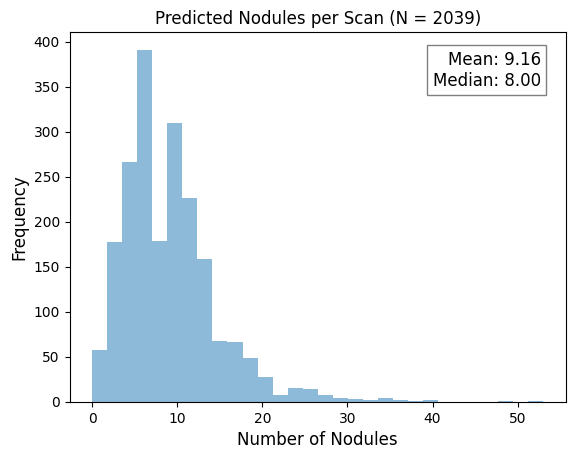

[14, 16, 26, 27, 13, 18, 28, 18, 28, 24, 42, 27, 33, 28, 19, 16, 18, 24, 21, 16, 10, 40, 41, 24, 21, 44, 24, 19, 32, 54, 37, 27, 32, 26, 29, 25, 21, 23, 16, 22, 39, 29, 20, 15, 24, 22, 15, 23, 21, 30, 20, 29, 42, 10, 24, 17, 27, 26, 25, 28, 9, 18, 30, 25, 87, 40, 47, 47, 33, 31, 7, 25, 13, 41, 56, 25, 18, 31, 23, 19, 15, 31, 32, 55, 19, 59, 14, 12, 25, 4, 13, 25, 21, 33, 22, 39, 30, 14, 30, 30, 52, 18, 31, 37, 39, 22, 31, 51, 15, 19, 29, 28, 25, 24, 2, 15, 26, 37, 23, 12, 10, 19, 8, 13, 3, 47, 14, 17, 40, 43, 18, 26, 40, 38, 27, 62, 23, 39, 35, 41, 106, 35, 21, 45, 64, 42, 54, 49, 24, 22, 42, 34, 80, 27, 38, 35, 73, 18, 26, 21, 19, 33, 23, 26, 15, 26, 13, 43, 86, 51, 12, 39, 24, 15, 44, 18, 18, 16, 20, 10, 27, 35, 28, 13, 20, 34, 20, 22, 5, 8, 30, 43, 1, 21, 22, 28, 21, 8, 27, 21, 17, 18, 20, 35, 29, 2, 28, 30, 14, 6, 19, 9, 7, 40, 29, 31, 45, 19, 31, 45, 16, 12, 25, 27, 9, 19, 15, 37, 33, 25, 26, 40, 49, 26, 25, 18, 14, 19, 21, 16, 22, 14, 41, 29, 20, 32, 42, 4, 46, 13, 7, 13, 46, 25,

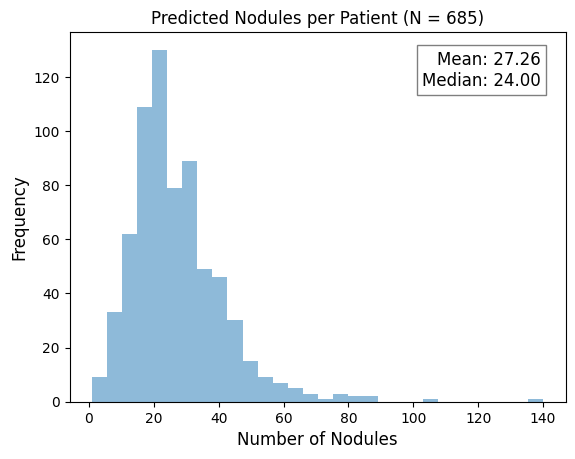

[76.9366625547409, 35.8428955078125, 167.6530258655548, 197.75390625, 164.0625, 46.966552734375, 48.828125, 227.4169921875, 156.25, 219.32690370082855, 169.3267822265625, 1065.4296875, 32.2265625, 78.125, 333.251953125, 714.88037109375, 303.3935546875, 40.283203125, 48.44970703125, 649.4140625, 274.658203125, 225.439453125, 56.35986328125, 279.82177734375, 673.35205078125, 1856.9091796875, 101.84326171875, 84.04541015625, 29.1046142578125, 194.03076171875, 23.80322265625, 21.43157958984375, 228.02047729492188, 106.7041015625, 134.3045654296875, 142.97103881835938, 720.6630859375, 336.4757995605469, 182.56301879882812, 76.33447265625, 93.5712890625, 37.7568359375, 45.14404296875, 33.65283203125, 72.23046875, 412.2007141113281, 75.01052856445312, 341.47650146484375, 144.43740844726562, 22.728729248046875, 71.11892700195312, 65.25344848632812, 42.52471923828125, 24.195098876953125, 259.54742431640625, 754.4471740722656, 200.18917179107666, 328.38134765625, 203.39733159542084, 104.07714843

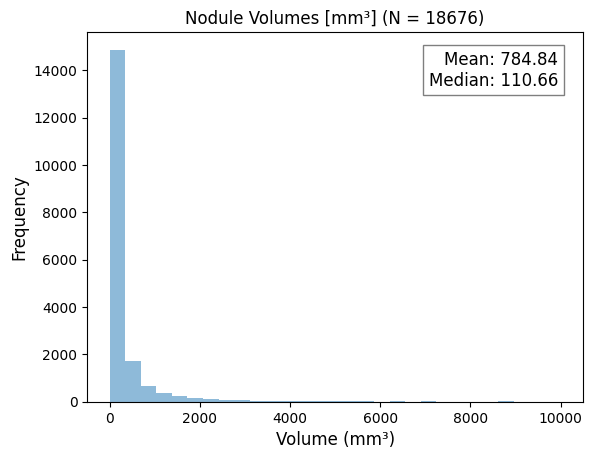

[76.9366625547409, 35.8428955078125, 167.6530258655548, 197.75390625, 164.0625, 46.966552734375, 48.828125, 227.4169921875, 156.25, 333.251953125, 714.88037109375, 303.3935546875, 40.283203125, 48.44970703125, 23.80322265625, 21.43157958984375, 228.02047729492188, 106.7041015625, 134.3045654296875, 142.97103881835938, 720.6630859375, 336.4757995605469, 182.56301879882812, 200.18917179107666, 328.38134765625, 203.39733159542084, 104.0771484375, 98.69384765625, 220.07976257801056, 144.15283203125, 256.60400390625, 37.214653730392456, 90.91796875, 110.15625, 141.12472534179688, 87.6826171875, 82.03125, 80.37567138671875, 334.58709716796875, 64.84860229492188, 275.17451667785645, 88.10760498046875, 73.81988525390625, 153.9898681640625, 48.41949462890625, 54.76959228515625, 45.24444580078125, 39.6881103515625, 23.01910400390625, 100.2532958984375, 99.86572265625, 100.9368896484375, 67.2027587890625, 56.35986328125, 65.42205810546875, 3407.5103759765625, 1948.86474609375, 1592.559814453125, 

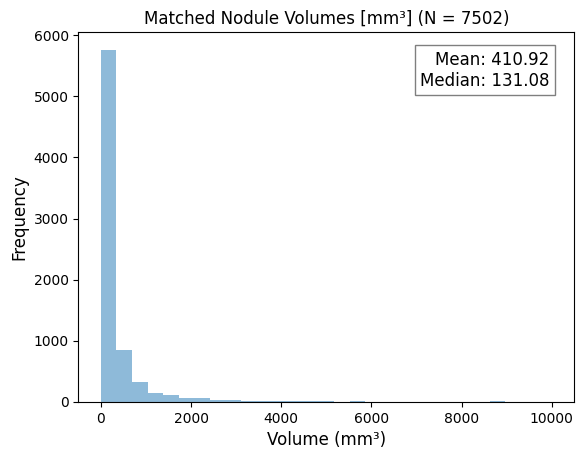

In [378]:
nodules_per_scan, nodules_per_patient, all_volumes, matched_volumes = compute_distributions(data, should_prune_t0)

# plot_distribution(nodules_per_scan, "Predicted Nodules per Scan\n", "Number of Nodules", "Frequency")
plot_distribution(nodules_per_scan, "Predicted Nodules per Scan", "Number of Nodules", "Frequency")
plot_distribution(nodules_per_patient, "Predicted Nodules per Patient", "Number of Nodules", "Frequency")
plot_distribution(all_volumes, "Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 10000))
# plot_distribution(all_volumes, "Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 2500))
# plot_distribution(all_volumes, "Nodule Volumes (mm³)", "Volume (mm³)", "Frequency")
plot_distribution(matched_volumes, "Matched Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 10000))
# plot_distribution(matched_volumes, "Matched Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 2500))

## Registration

In [379]:
all_bbox_mask_iou_vals = []

all_predicted_ious_pairwise = []
all_predicted_min_dist_pairwise = []
all_predicted_centroid_dist_pairwise = []

for pid_entry in data.values():
    for v in pid_entry["reg_metrics"].values():
        if v is not None:
            all_bbox_mask_iou_vals.append(v)
    
    # TODO: broken!
    
    # for nodule_idx in pid_entry["matched_nodules"]:
    #     for tp in pid_entry["matched_nodules"][nodule_idx]:
    #         curr_entry = pid_entry["matched_nodules"][nodule_idx][tp]

    #         if tp == "T0":
    #             # print(curr_entry)
    #             all_predicted_ious_pairwise.append(curr_entry["iou_with_T1_nodule_after_reg"])
    #             all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T1_nodule"])
    #             all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T1_nodule"])
    #         elif tp == "T1":
    #             if "iou_with_T0_nodule_after_reg" in curr_entry and "min_distance_to_T0_nodule" in curr_entry and "centroid_distance_to_T0_nodule" in curr_entry:
    #                 all_predicted_ious_pairwise.append(curr_entry["iou_with_T0_nodule_after_reg"])
    #                 all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T0_nodule"])
    #                 all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T0_nodule"])

    #             if "iou_with_T2_nodule_after_reg" in curr_entry and "min_distance_to_T2_nodule" in curr_entry and "centroid_distance_to_T2_nodule" in curr_entry:
    #                 all_predicted_ious_pairwise.append(curr_entry["iou_with_T2_nodule_after_reg"])
    #                 all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T2_nodule"])
    #                 all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T2_nodule"])
    #         elif tp == "T2":
    #             print(curr_entry)
    #             all_predicted_ious_pairwise.append(curr_entry["iou_with_registered_T1_nodule"])
    #             all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T1_nodule"])
    #             all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T1_nodule"])


[]


/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  

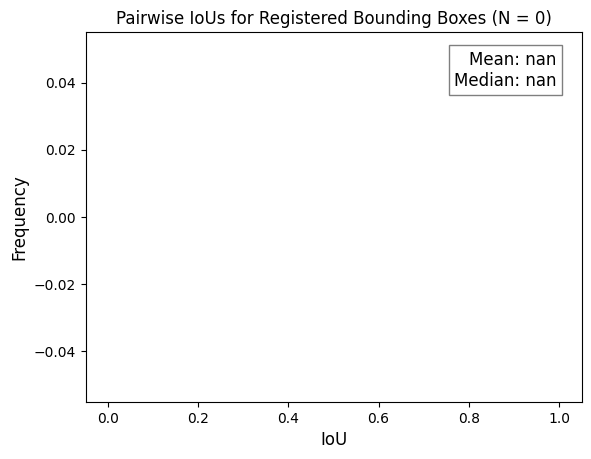

In [380]:
plot_distribution(all_bbox_mask_iou_vals, "Pairwise IoUs for Registered Bounding Boxes", "IoU", "Frequency")

# plot_distribution(all_bbox_mask_iou_vals, "Pairwise IoUs for Predicted Matched Longitudinal Nodules", "IoU", "Frequency")
# plot_distribution(all_bbox_mask_iou_vals, "Pairwise Minimum Distance for Predicted Matched Longitudinal Nodules", "Minimum Distance", "Frequency")
# plot_distribution(all_bbox_mask_iou_vals, "Pairwise Centroid Distance for Predicted Matched Longitudinal Nodules", "Centroid Distance", "Frequency")

## Growth

In [381]:
metadata.columns

Index(['PID', 'IsSmallCell', 'CancerTP', 'NumExams', 'Days2Cancer_0',
       'DaysSinceRand_0', 'Annotated_0', 'Days2FUP_0', 'Series_0',
       'abnormalities_0', 'attentuations_0', 'longest_diameter_0',
       'perp_diameter_0', 'growth_0', 'change_0', 'exists_0', 'slice_number_0',
       'age_0', 'years_since_quit_smoking_0', 'Days2Cancer_1',
       'DaysSinceRand_1', 'Annotated_1', 'Days2FUP_1', 'Series_1',
       'abnormalities_1', 'attentuations_1', 'longest_diameter_1',
       'perp_diameter_1', 'growth_1', 'change_1', 'exists_1', 'slice_number_1',
       'age_1', 'years_since_quit_smoking_1', 'Days2Cancer_2',
       'DaysSinceRand_2', 'Annotated_2', 'Days2FUP_2', 'Series_2',
       'abnormalities_2', 'attentuations_2', 'longest_diameter_2',
       'perp_diameter_2', 'growth_2', 'change_2', 'exists_2', 'slice_number_2',
       'age_2', 'years_since_quit_smoking_2', 'age_start_smoking',
       'age_quit_smoking', 'years_smoking', 'is_smoker', 'family_hx'],
      dtype='object')

In [382]:
def volume_percentage_change(v0, v1):
    return ((v1 - v0) / v0) * 100 if v0 > 0 else np.nan

def volume_doubling_time(v0, v1, time_diff):
    if v0 > 0 and v1 > v0 and time_diff > 0:
        return (np.log(2) / np.log(v1 / v0)) * time_diff
    return np.nan

In [383]:
metadata[["DaysSinceRand_1", "DaysSinceRand_0"]]

,DaysSinceRand_1,DaysSinceRand_0
0,339.0,15.0
1,336.0,49.0
2,432.0,25.0
3,362.0,40.0
4,414.0,16.0
...,...,...
8090,372.0,9.0
8091,344.0,20.0
8092,392.0,18.0
8093,464.0,27.0


In [384]:
def compute_growth_statistics(data, df):
    growth_data = []
    unmatched_earlier = {"NSCLC": 0, "SCLC": 0, "benign": 0}
    unmatched_later = {"NSCLC": 0, "SCLC": 0, "benign": 0}
    early_detection = {"NSCLC": 0, "SCLC": 0, "benign": 0}

    for pid in data:
        patient_data = data[pid]
        if is_cancer:
            cancer_type = "NSCLC" if df.loc[df["PID"] == int(pid), "IsSmallCell"].values[0] == 0 else "SCLC"
        else:
            cancer_type = "benign"

        matched_nodules = patient_data["matched_nodules"]
        for nodule_entry in matched_nodules.values():
            # skip T0 and T2 pairs (we want one-timepoint changes)
            if "T0" in nodule_entry and "T1" in nodule_entry:
                T0, T1 = nodule_entry["T0"], nodule_entry["T1"]
                v0, v1 = T0["mask_volume"], T1["mask_volume"]

                time_diff = df.loc[df["PID"] == int(pid), "DaysSinceRand_1"].values[0] - df.loc[df["PID"] == int(pid), "DaysSinceRand_0"].values[0]
                    
                growth_data.append({
                    "PID": pid,
                    "volume_change": volume_percentage_change(v0, v1),
                    "doubling_time": volume_doubling_time(v0, v1, time_diff),
                    "cancer_type": cancer_type,
                    "first": "T0",
                    "second": "T1",
                })

            if "T1" in nodule_entry and "T2" in nodule_entry:
                T1, T2 = nodule_entry["T1"], nodule_entry["T2"]
                v1, v2 = T1["mask_volume"], T2["mask_volume"]

                time_diff = df.loc[df["PID"] == int(pid), "DaysSinceRand_2"].values[0] - df.loc[df["PID"] == int(pid), "DaysSinceRand_1"].values[0]
                    
                growth_data.append({
                    "PID": pid,
                    "volume_change": volume_percentage_change(v1, v2),
                    "doubling_time": volume_doubling_time(v1, v2, time_diff),
                    "cancer_type": cancer_type,
                    "first": "T1",
                    "second": "T2",
                })
        
        # Unmatched nodules appearing earlier or later
        unmatched_nodules = patient_data["unmatched_nodules"]
        for nodule in unmatched_nodules.values():
            timepoint = nodule["timepoint"]
            if timepoint == "T2":
                if patient_data["total_num_nodules"].get("T0", 0) > 0 or patient_data["total_num_nodules"].get("T1", 0) > 0:
                    unmatched_earlier[cancer_type] += 1
            elif timepoint == "T1":
                if patient_data["total_num_nodules"].get("T0", 0) > 0:
                    unmatched_earlier[cancer_type] += 1
                if patient_data["total_num_nodules"].get("T2", 0) > 0:
                    unmatched_later[cancer_type] += 1
            elif timepoint == "T0":
                if patient_data["total_num_nodules"].get("T1", 0) > 0 or patient_data["total_num_nodules"].get("T2", 0) > 0:
                    unmatched_later[cancer_type] += 1
        
        
        
        # # Matched nodules with an earlier scan
        # previous_scans = df.loc[df["PID"] == int(pid), "Series_0"].values
        # if len(previous_scans) > 1:
        #     matched_earlier_scan["total"] += 1
        #     if np.isnan(df.loc[df["PID"] == int(pid), "longest_diameter_0"].values[0]):
        #         matched_earlier_scan["no_diameter"] += 1

    growth_df = pd.DataFrame(growth_data)

    # # Output results
    # print("Growth Analysis:")
    # # print(growth_df.groupby("cancer_type")["volume_change", "doubling_time"].describe())

    # print("\nUnmatched nodules appearing earlier:", unmatched_earlier)
    # print("Unmatched nodules appearing later:", unmatched_later)
    # # print("\nMatched nodules with an earlier scan:", matched_earlier_scan)

    return growth_df, unmatched_earlier, unmatched_later, early_detection


In [385]:
growth_df, unmatched_earlier, unmatched_later, early_detection = compute_growth_statistics(data, metadata)

In [386]:
growth_df[growth_df["PID"] == "126967"]

,PID,volume_change,doubling_time,cancer_type,first,second


In [387]:
cols = [col for col in metadata.columns if "_0" in col]

In [388]:
annotations = json.load(open("/data/rbg/shared/datasets/NLST/NLST/annotations_122020.json", "r"))

In [389]:
annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"]

{'1.2.840.113654.2.55.163157187122431509690781522115404072036': [{'x': 0.57159541015625,
   'y': 0.58550396484375,
   'width': 0.0838051953125,
   'height': 0.07701021484375,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.253307140210856805054979155186064149226': [{'x': 0.56593287109375,
   'y': 0.58323896484375,
   'width': 0.09060025390625,
   'height': 0.0792751953125,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.58364372794881369367486462306831359202': [{'x': 0.5703125,
   'y': 0.583984375,
   'width': 0.0859375,
   'height': 0.078125,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.106110028426812472195508696323718613319': [{'x': 0.568359375,
   'y': 0.583984375,
   'width': 0.087890625,
   'height': 0.078125,
   'user': 'pbourgouin@bwh.harvard.edu'}]}

In [390]:
import torch
import math
import numpy as np
slice_ids = list(annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"].keys())
mask = torch.zeros((197, 512, 512))
W, H = mask.shape[1:]
for i, slice in enumerate(slice_ids):
    for bbox in annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"].get(slice, []):
        x_left, y_top = bbox["x"] * W, bbox["y"] * H
        x_right, y_bottom = x_left + bbox["width"] * W, y_top + bbox["height"] * H
        x_left, y_top = math.floor(x_left), math.floor(y_top)
        x_right, y_bottom = math.ceil(x_right), math.ceil(y_bottom)
        mask[i,y_top:y_bottom, x_left:x_right] = 1
        print(x_left)

292
289
292
291


In [391]:
np.count_nonzero(mask)

7380

In [392]:
growth_df[growth_df["volume_change"] < 0].describe()

,volume_change,doubling_time
count,2133.000000,0.0
mean,-34.689902,NaN
std,24.544197,NaN
min,-99.714173,NaN
25%,-52.051779,NaN
50%,-30.495473,NaN
75%,-14.008196,NaN
max,-0.001331,NaN


In [393]:
# days_to_cancer_from_earliest_matched_scan = get_days_to_cancer_from_earliest_matched_scan(data, metadata)
# days_to_cancer_from_last_scan = get_days_to_cancer_from_last_scan(data, metadata)

In [394]:
# plot_distribution(days_to_cancer_from_earliest_matched_scan, "Days to Cancer from Earliest Matched Scan", "Days", "Frequency")
# plot_distribution(days_to_cancer_from_last_scan, "Days to Cancer from Last Scan", "Days", "Frequency")

[-53.41246381423153, 17.95427206221965, -17.037037037037038, 3.9636127355425597, -31.293612453032743, 114.51648351648352, -57.560234277615564, 20.272727272727273, -9.963537713594125, 963.9462030273256, 25.86635702191919, 6.45285092204035, -53.31024911275559, -45.742600496896365, 64.03551936313443, -48.83062249581492, -5.172413793103448, -34.49973303194887, 78.00829875518673, 144.30690503979923, 28.11322584219858, -37.868706581970535, -2.018229166666667, -80.61831946186295, -67.9811902482179, -16.216216216216218, -68.55670103092784, -17.391304347826086, -42.0, -0.3865940154028797, 1.0726072607260726, -16.13459879206212, 16.07916395928092, -42.8067846885067, -18.28269162109852, -35.62384882017665, 6.940501937460574, -4.401913875598086, -10.722125634406336, 55.07450810185185, -16.279063953497257, 13.245033112582782, -11.695906432748536, 3.0, 26.21359223300971, 3.739612188365651, -54.73965287049399, 15.909090909090908, 2.564102564102564, 4129.80896978227, -95.6911816707706, -28.36845281308

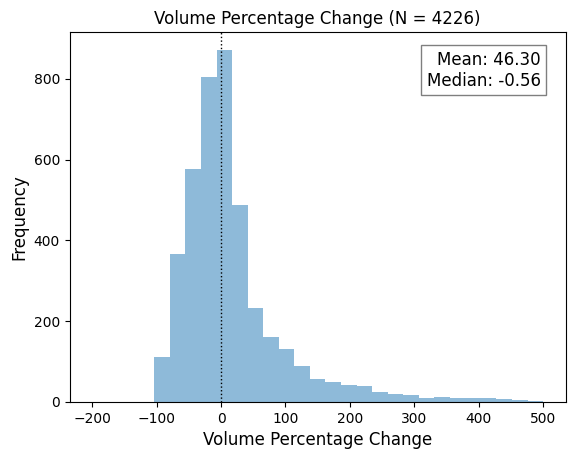

[]


/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  

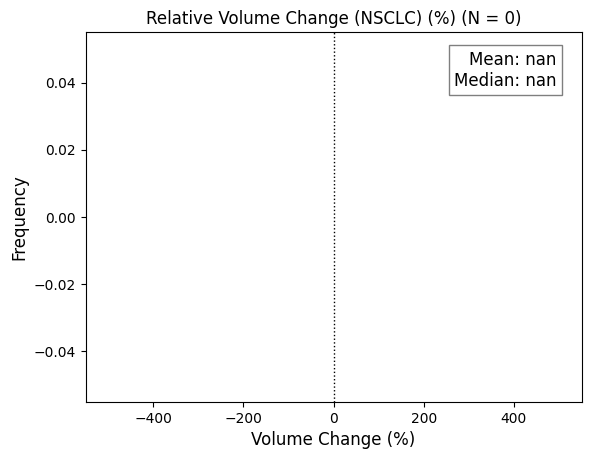

[]


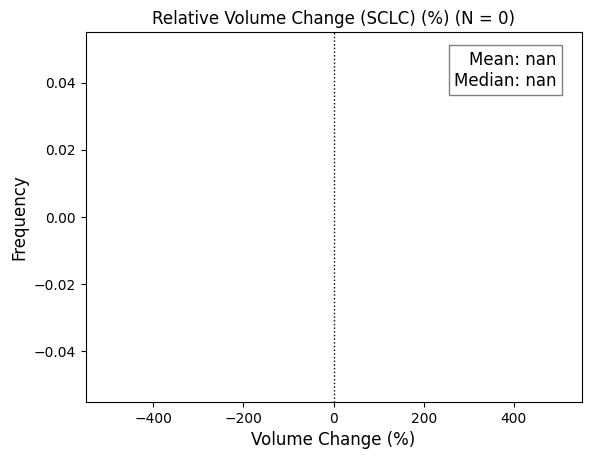

[-53.41246381423153, 17.95427206221965, -17.037037037037038, 3.9636127355425597, -31.293612453032743, 114.51648351648352, -57.560234277615564, 20.272727272727273, -9.963537713594125, 963.9462030273256, 25.86635702191919, 6.45285092204035, -53.31024911275559, -45.742600496896365, 64.03551936313443, -48.83062249581492, -5.172413793103448, -34.49973303194887, 78.00829875518673, 144.30690503979923, 28.11322584219858, -37.868706581970535, -2.018229166666667, -80.61831946186295, -67.9811902482179, -16.216216216216218, -68.55670103092784, -17.391304347826086, -42.0, -0.3865940154028797, 1.0726072607260726, -16.13459879206212, 16.07916395928092, -42.8067846885067, -18.28269162109852, -35.62384882017665, 6.940501937460574, -4.401913875598086, -10.722125634406336, 55.07450810185185, -16.279063953497257, 13.245033112582782, -11.695906432748536, 3.0, 26.21359223300971, 3.739612188365651, -54.73965287049399, 15.909090909090908, 2.564102564102564, 4129.80896978227, -95.6911816707706, -28.36845281308

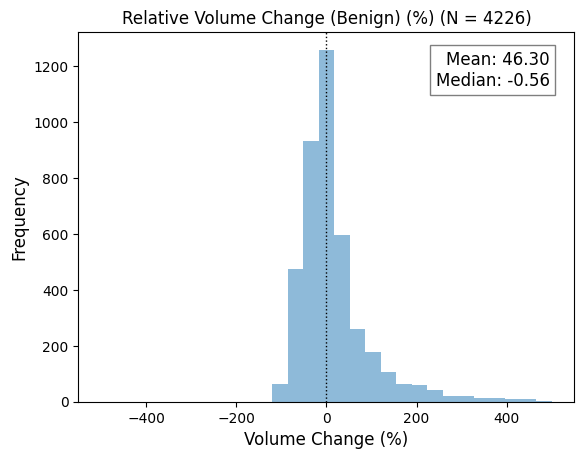

In [395]:
# plot_distribution(growth_df["volume_change"].dropna().tolist(), "Volume Change (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)
plot_distribution(growth_df["volume_change"].dropna().tolist(), "Volume Percentage Change", "Volume Percentage Change", "Frequency", xlim=(-200, 500), drop_vert_line=True)
plot_distribution(growth_df[growth_df["cancer_type"] == "NSCLC"]["volume_change"].dropna().tolist(), "Relative Volume Change (NSCLC) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)
plot_distribution(growth_df[growth_df["cancer_type"] == "SCLC"]["volume_change"].dropna().tolist(), "Relative Volume Change (SCLC) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)
plot_distribution(growth_df[growth_df["cancer_type"] == "benign"]["volume_change"].dropna().tolist(), "Relative Volume Change (Benign) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)

In [396]:
metadata["Days2Cancer_0"]

0      -16.0
1      -50.0
2      -26.0
3      -41.0
4      -17.0
        ... 
8090   -10.0
8091   -21.0
8092   -19.0
8093   -28.0
8094   -19.0
Name: Days2Cancer_0, Length: 8095, dtype: float64

In [397]:
# of the pairs

increase_threshold = 25
decrease_threshold = -25

# increase_threshold = 20
# decrease_threshold = -10

volume_change_vals = growth_df["volume_change"].dropna().tolist()

print(f"{len([val for val in volume_change_vals if val >= increase_threshold]) / len(volume_change_vals)}% of pairs increase in volume")
print(f"{len([val for val in volume_change_vals if val <= decrease_threshold]) / len(volume_change_vals)}% of pairs decrease in volume")
print(f"{len([val for val in volume_change_vals if val < increase_threshold and val > decrease_threshold]) / len(volume_change_vals)}% of pairs maintain the same volume")

0.30430667297681024% of pairs increase in volume
0.28963558920965454% of pairs decrease in volume
0.40605773781353527% of pairs maintain the same volume


In [398]:
ranges = [(-100, -25), (-25, 25), (25, 50), (50, 100), (100, 200), (200, float("inf"))]

volume_change_val = np.array(growth_df["volume_change"].dropna().tolist())

sum_ = 0
for (start_, stop_) in ranges:
    res = np.mean(np.logical_and(volume_change_val >= start_, volume_change_val < stop_))
    print(start_, stop_, res)

    sum_ += res

-100 -25 0.2893989588263133
-25 25 0.4062943681968765
25 50 0.08802650260293422
50 100 0.08566019876952201
100 200 0.06578324656885944
200 inf 0.06483672503549456


In [399]:
sum_

1.0

In [400]:
growth_df["volume_change"].min()

-99.71417292393957

In [401]:
# plot_binned_dist(growth_df["volume_change"].dropna().tolist(), "Percent Volume Change\n", "Relative Volume Change (%)", "Frequency", xlim=(-200, 500))

In [402]:
growth_df["doubling_time"]

0               NaN
1       1431.403827
2               NaN
3       5367.459348
4               NaN
           ...     
4221            NaN
4222    1436.570319
4223            NaN
4224    3440.378925
4225    6333.263078
Name: doubling_time, Length: 4226, dtype: float64

[1431.403827235667, 5367.459347751545, 372.35880367128215, 1539.5618320110386, 102.89171749885438, 937.0497939039881, 3890.723338179401, 485.9887877588329, 437.5291854739349, 269.2647188646522, 1015.6135309352742, 22739.01075673767, 1627.0818284133766, 3615.3904905976565, 552.9561799364283, 1916.992277697031, 8066.721654150582, 1220.7202585038997, 6494.62437268682, 1924.9393530563727, 11224.91900586036, 74.03951402642984, 406.0364227066014, 1340.343992370759, 1196.9599631084052, 4400.014962979222, 270.5757996297813, 1261.9038083517642, 214.2741400882084, 1123.5413631956533, 5230.781494362977, 320.1159170644807, 468.8233762017715, 794.0451181378471, 2343.2768016091163, 688.8192602971022, 351.26863113074785, 222.88107236622298, 125.95363022951244, 1272.5727281953318, 1693.940538403811, 164.24582140910877, 11971.195569495034, 3414.8232408067615, 327.0, 374.1340376672547, 296.7052380009201, 2098.400953597732, 18390.74784619332, 3313.3946448032975, 4506.967862439886, 1567.705368126253, 1664

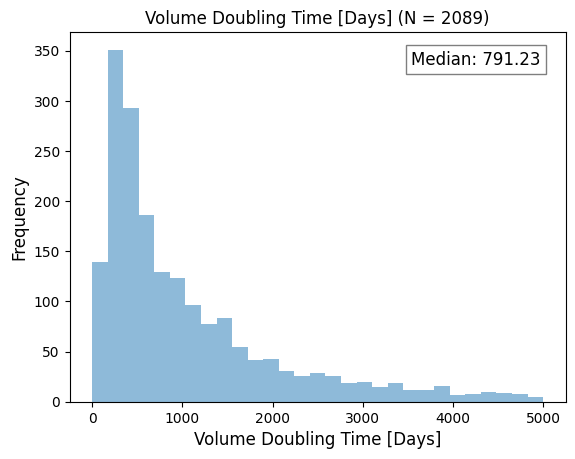

[]


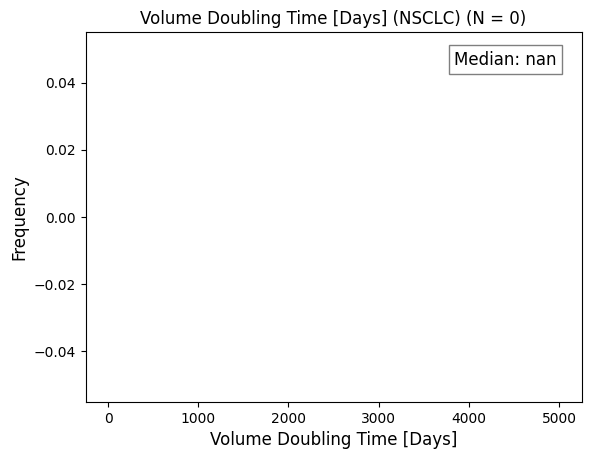

[]


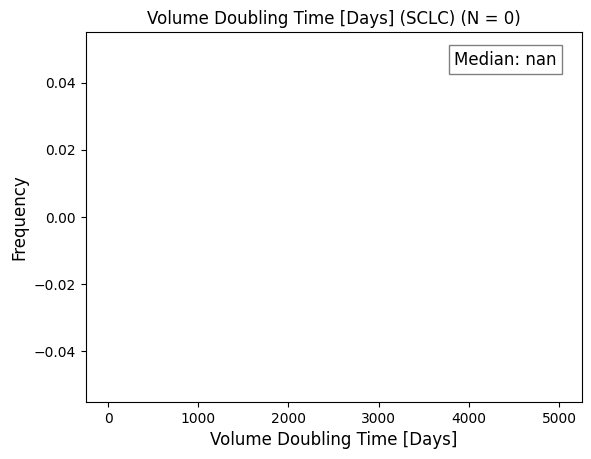

[1431.403827235667, 5367.459347751545, 372.35880367128215, 1539.5618320110386, 102.89171749885438, 937.0497939039881, 3890.723338179401, 485.9887877588329, 437.5291854739349, 269.2647188646522, 1015.6135309352742, 22739.01075673767, 1627.0818284133766, 3615.3904905976565, 552.9561799364283, 1916.992277697031, 8066.721654150582, 1220.7202585038997, 6494.62437268682, 1924.9393530563727, 11224.91900586036, 74.03951402642984, 406.0364227066014, 1340.343992370759, 1196.9599631084052, 4400.014962979222, 270.5757996297813, 1261.9038083517642, 214.2741400882084, 1123.5413631956533, 5230.781494362977, 320.1159170644807, 468.8233762017715, 794.0451181378471, 2343.2768016091163, 688.8192602971022, 351.26863113074785, 222.88107236622298, 125.95363022951244, 1272.5727281953318, 1693.940538403811, 164.24582140910877, 11971.195569495034, 3414.8232408067615, 327.0, 374.1340376672547, 296.7052380009201, 2098.400953597732, 18390.74784619332, 3313.3946448032975, 4506.967862439886, 1567.705368126253, 1664

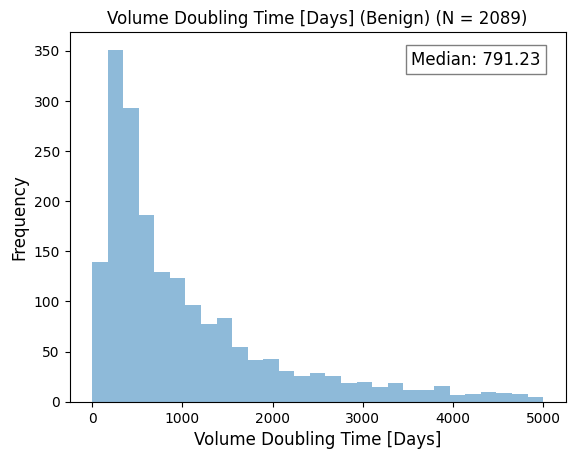

In [403]:
plot_distribution(growth_df["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days]", "Volume Doubling Time [Days]", "Frequency", with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (NSCLC)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (SCLC)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "benign"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (Benign)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))

In [404]:
data_biggest_only = {}

In [405]:
for pid in data:
    data_biggest_only[pid] = data[pid].copy() # biggest only from latest one

    if data[pid]["matched_nodules"]:
        data_biggest_only[pid]["matched_nodules"] = {}

        if data[pid]["num_scans"] == 2:
            assert "T1" in data[pid]["total_num_voxels"] or "T2" in data[pid]["total_num_voxels"]

            if "T2" in data[pid]["total_num_voxels"]:
                latest_tp = "T2"
            else:
                latest_tp = "T1"

        elif data[pid]["num_scans"] == 3:
            latest_tp = "T2"
        
        latest_nodule_idx_to_latest_volume = {}
        for nodule_idx in data[pid]["matched_nodules"]:
            latest_nodule_idx_to_latest_volume[nodule_idx] = data[pid]["matched_nodules"][nodule_idx].get(latest_tp, {}).get("mask_volume", 0)
            
        latest_nodule_idx_to_keep = max([(k, v) for (k, v) in latest_nodule_idx_to_latest_volume.items()], key=lambda x:x[1])[0]

        data_biggest_only[pid]["matched_nodules"][latest_nodule_idx_to_keep] = data[pid]["matched_nodules"][latest_nodule_idx_to_keep]

In [406]:
growth_df_biggest_only, _, _, _ = compute_growth_statistics(data_biggest_only, metadata)

In [407]:
if is_cancer:
    plot_distribution_overlay(growth_df[growth_df["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), growth_df[growth_df["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time (Days) (NSCLC)", "Volume Doubling Time (Days)", "Frequency", "NSCLC", "SCLC", xlim=(0, 5000))

In [408]:
if is_cancer:
    plot_distribution_overlay(growth_df_biggest_only[growth_df_biggest_only["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), growth_df_biggest_only[growth_df_biggest_only["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time (Days) (NSCLC)", "Volume Doubling Time (Days)", "Frequency", "NSCLC", "SCLC", (0, 5000))

In [409]:
print(f"Unmatched Earlier (SCLC): {unmatched_earlier['SCLC']}")
print(f"Unmatched Earlier (NSCLC): {unmatched_earlier['NSCLC']}")
print(f"Unmatched Earlier (Benign): {unmatched_earlier['benign']}")
print("\n")
print(f"Unmatched Later (SCLC): {unmatched_later['SCLC']}")
print(f"Unmatched Later (NSCLC): {unmatched_later['NSCLC']}")
print(f"Unmatched Later (Benign): {unmatched_later['benign']}")

Unmatched Earlier (SCLC): 0
Unmatched Earlier (NSCLC): 0
Unmatched Earlier (Benign): 6897


Unmatched Later (SCLC): 0
Unmatched Later (NSCLC): 0
Unmatched Later (Benign): 7364


## Novel Nodules

How often is there a novel nodule (i.e., an unmatched nodule in T1 and there is a scan for T0, or an unmatched nodule in T2 and there is a scan in T1)?

In [410]:
min_vol_threshold = (4/3) * math.pi * (3/2)**2 # assume

In [411]:
min_vol_threshold = 500

# Counters for T0→T1
appearing_01 = 0
den_01       = 0

# Counters for T1→T2
appearing_12 = 0
den_12       = 0

for pid, pid_entry in data.items():
    scans = pid_entry["total_num_nodules"].keys()
    has_t0 = "T0" in scans
    has_t1 = "T1" in scans
    has_t2 = "T2" in scans

    # Precompute unmatched volumes
    unmatched = pid_entry["unmatched_nodules"].values()
    unmatched_t1 = any(
        e["timepoint"] == "T1" and e["mask_volume"] >= min_vol_threshold
        for e in unmatched
    )
    unmatched_t2 = any(
        e["timepoint"] == "T2" and e["mask_volume"] >= min_vol_threshold
        for e in unmatched
    )

    # Precompute “newly matched” at T1 (i.e. present only at T1 in the match dict)
    matched = pid_entry["matched_nodules"].values()
    new_at_t1 = any(
        ("T1" in m) and ("T0" not in m) and (m["T1"]["mask_volume"] >= min_vol_threshold)
        for m in matched
    )

    # --- T0 → T1 appearance ---
    if has_t0 and has_t1:
        den_01 += 1
        # either truly new at T1, or an unmatched T1 above threshold
        if new_at_t1 or unmatched_t1:
            appearing_01 += 1

    # --- T1 → T2 appearance ---
    if has_t1 and has_t2:
        den_12 += 1
        if unmatched_t2:
            appearing_12 += 1

# Compute rates
rate_01 = appearing_01 / den_01 if den_01 else float('nan')
rate_12 = appearing_12 / den_12 if den_12 else float('nan')

print(f"T0→T1 appearance: {appearing_01}/{den_01} = {rate_01:.4f}")
print(f"T1→T2 appearance: {appearing_12}/{den_12} = {rate_12:.4f}")

T0→T1 appearance: 323/674 = 0.4792
T1→T2 appearance: 317/672 = 0.4717


In [412]:
disappearing_01 = 0  # T0→T1 lost
den_01         = 0  # T0→T1 eligible

disappearing_12 = 0  # T1→T2 lost
den_12         = 0  # T1→T2 eligible

for pid, pid_entry in data.items():
    scans = pid_entry["total_num_nodules"].keys()
    has_t0 = "T0" in scans
    has_t1 = "T1" in scans
    has_t2 = "T2" in scans

    # 1) T0 → T1
    if has_t0 and has_t1:
        den_01 += 1
        # did any T0 nodule go unmatched forward?
        lost_from_t0 = any(
            entry["timepoint"] == "T0"
            for entry in pid_entry["unmatched_nodules"].values()
        )
        if lost_from_t0:
            disappearing_01 += 1

    # 2) T1 → T2
    if has_t1 and has_t2:
        den_12 += 1
        lost_from_t1 = any(
            entry["timepoint"] == "T1"
            for entry in pid_entry["unmatched_nodules"].values()
        )
        if lost_from_t1:
            disappearing_12 += 1

# Compute rates
rate_01 = disappearing_01 / den_01 if den_01 else float('nan')
rate_12 = disappearing_12 / den_12 if den_12 else float('nan')

print(f"T0→T1 disappearance: {disappearing_01}/{den_01} = {rate_01:.4f}")
print(f"T1→T2 disappearance: {disappearing_12}/{den_12} = {rate_12:.4f}")

T0→T1 disappearance: 658/674 = 0.9763
T1→T2 disappearance: 630/672 = 0.9375


<!-- How many patients of 685 have an unmatched nodule?

Exclude patients -->

In [413]:
# disappearing = 0
# denom1 = 0

# for pid, pid_entry in data.items():
#     unmatched_t0 = any([entry["timepoint"] == "T0" for entry in data[pid]["unmatched_nodules"].values()])
#     unmatched_t1 = any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()])
#     unmatched_t2 = any([entry["timepoint"] == "T2" for entry in data[pid]["unmatched_nodules"].values()])

#     scans = list(pid_entry["total_num_nodules"].keys())

#     has_t0 = "T0" in scans
#     has_t1 = "T1" in scans
#     has_t2 = "T2" in scans

#     has_match_at_T1_without_T0 = any(["T1" in entry and "T0" not in entry for entry in data[pid]["matched_nodules"].values()])
    
#     ###

#     if (unmatched_t0 and (has_t1 or has_t2)) or (unmatched_t1 and has_t2):
#         disappearing += 1

#     if len(scans) > 1: # all of the people we are allowed to count
#         denom1 += 1

# print(disappearing / denom1)

In [414]:
min_vol_threshold1 = 500

appearing = 0
denom1 = 0

for pid, pid_entry in data.items():
    unmatched_t0 = any([entry["timepoint"] == "T0" and entry["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["unmatched_nodules"].values()])
    unmatched_t1 = any([entry["timepoint"] == "T1" and entry["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["unmatched_nodules"].values()])
    unmatched_t2 = any([entry["timepoint"] == "T2" and entry["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["unmatched_nodules"].values()])

    scans = list(pid_entry["total_num_nodules"].keys())

    has_t0 = "T0" in scans
    has_t1 = "T1" in scans
    has_t2 = "T2" in scans

    has_match_at_T1_without_T0 = any(["T1" in entry and "T0" not in entry and entry["T1"]["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["matched_nodules"].values()])
    
    ###

    if (has_t0 and (has_match_at_T1_without_T0 or unmatched_t1)) or ((has_t0 or has_t1) and unmatched_t2):
        appearing += 1

    if len(scans) > 1: # all of the people we are allowed to count
        denom1 += 1

print(appearing / denom1)

0.6866764275256223


In [415]:
pid_entry

{'matched_nodules': {'0': {'T0': {'mask_volume': 66.4378856420517,
    'instance_label': 2,
    'centroid_distance_to_T1_nodule': 4.966692814642062,
    'min_distance_to_T1_nodule': 0.0,
    'iou_with_T1_nodule_after_reg': 0.14814814814814814,
    'has_bbox_overlap': False,
    'mask_slice_range': [81, 82, 83],
    'bbox_slice_range': []},
   'T1': {'mask_volume': 75.9837646484375,
    'instance_label': 1,
    'centroid_distance_to_T0_nodule': 4.966692814642062,
    'min_distance_to_T0_nodule': 0.0,
    'iou_with_T0_nodule_after_reg': 0.14814814814814814,
    'centroid_distance_to_T2_nodule': 4.0228009845617025,
    'min_distance_to_T2_nodule': 0.0,
    'iou_with_T2_nodule_after_reg': 0.07692307692307693,
    'has_bbox_overlap': False,
    'mask_slice_range': [96, 97, 98],
    'bbox_slice_range': []},
   'T2': {'mask_volume': 85.58724975585938,
    'instance_label': 8,
    'centroid_distance_to_T1_nodule': 4.0228009845617025,
    'min_distance_to_T1_nodule': 0.0,
    'iou_with_register

In [416]:
    # if len(data[pid]["unmatched_nodules"]) > 0:
    #     count1 += 1
    
    # if 
    #     disappeared0 += 1
    
    # if any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()]):
    #     disappeared1 += 1

In [417]:
pid_entry

{'matched_nodules': {'0': {'T0': {'mask_volume': 66.4378856420517,
    'instance_label': 2,
    'centroid_distance_to_T1_nodule': 4.966692814642062,
    'min_distance_to_T1_nodule': 0.0,
    'iou_with_T1_nodule_after_reg': 0.14814814814814814,
    'has_bbox_overlap': False,
    'mask_slice_range': [81, 82, 83],
    'bbox_slice_range': []},
   'T1': {'mask_volume': 75.9837646484375,
    'instance_label': 1,
    'centroid_distance_to_T0_nodule': 4.966692814642062,
    'min_distance_to_T0_nodule': 0.0,
    'iou_with_T0_nodule_after_reg': 0.14814814814814814,
    'centroid_distance_to_T2_nodule': 4.0228009845617025,
    'min_distance_to_T2_nodule': 0.0,
    'iou_with_T2_nodule_after_reg': 0.07692307692307693,
    'has_bbox_overlap': False,
    'mask_slice_range': [96, 97, 98],
    'bbox_slice_range': []},
   'T2': {'mask_volume': 85.58724975585938,
    'instance_label': 8,
    'centroid_distance_to_T1_nodule': 4.0228009845617025,
    'min_distance_to_T1_nodule': 0.0,
    'iou_with_register

In [418]:
novel_nodule_data = {}

for pid, pid_entry in data.items():
    # has_scan_T0 = "T0" in pid_entry["total_num_nodules"]
    # has_scan_T1 = "T1" in pid_entry["total_num_nodules"]

    has_unmatched_nodules_nodule_in_T0 = any([entry["timepoint"] == "T0" for entry in data[pid]["unmatched_nodules"].values()])
    has_unmatched_nodules_nodule_in_T1 = any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()])

    novel_nodule_data[pid] = {"unmatched_nodules": {}}

    for unmatched_nodule_id, unmatched_nodule_entry in data[pid]["unmatched_nodules"].items():
        if unmatched_nodule_entry["mask_volume"] >= min_vol_threshold:
            if (unmatched_nodule_entry["timepoint"] == "T1" and has_unmatched_nodules_nodule_in_T0) or (unmatched_nodule_entry["timepoint"] == "T2" and (has_unmatched_nodules_nodule_in_T1 or has_unmatched_nodules_nodule_in_T0)):
                novel_nodule_data[pid]["unmatched_nodules"][unmatched_nodule_id] = unmatched_nodule_entry


Over the number of nodules instead of patients

(Go nodule-by-nodule of the unmatched nodules -> does it appear? disappear?)

In [419]:
num_pids_with_at_least_one_novel_nodule = 0

for pid, pid_entry in novel_nodule_data.items():
    if pid_entry["unmatched_nodules"]:
        num_pids_with_at_least_one_novel_nodule += 1

print(f"{num_pids_with_at_least_one_novel_nodule * 100 / len(novel_nodule_data)}% of patients have at least one novel nodule")

64.23357664233576% of patients have at least one novel nodule


## Disappearing Nodules

In [420]:
disappearing_nodule_data = {}


for pid, pid_entry in data.items():
    has_unmatched_nodules_nodule_in_T1 = any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()])
    has_unmatched_nodules_nodule_in_T2 = any([entry["timepoint"] == "T2" for entry in data[pid]["unmatched_nodules"].values()])

    disappearing_nodule_data[pid] = {"unmatched_nodules": {}}

    # maybe add a minimum volume threshold?

    for unmatched_nodule_id, unmatched_nodule_entry in data[pid]["unmatched_nodules"].items():
        if unmatched_nodule_entry["mask_volume"] >= min_vol_threshold:
            if (unmatched_nodule_entry["timepoint"] == "T0" and not has_unmatched_nodules_nodule_in_T1) or (unmatched_nodule_entry["timepoint"] == "T1" and not has_unmatched_nodules_nodule_in_T2):
                disappearing_nodule_data[pid]["unmatched_nodules"][unmatched_nodule_id] = unmatched_nodule_entry


In [421]:
num_pids_with_at_least_one_disappearing_nodule = 0

for pid, pid_entry in disappearing_nodule_data.items():
    if pid_entry["unmatched_nodules"]:
        num_pids_with_at_least_one_disappearing_nodule += 1

print(f"{num_pids_with_at_least_one_disappearing_nodule * 100 / len(disappearing_nodule_data)}% of patients have at least one disappearing nodule")

3.9416058394160585% of patients have at least one disappearing nodule


In [422]:
num_pids_with_at_least_one_disappearing_nodule

27

## Early Detection

In [423]:
metadata

,PID,IsSmallCell,CancerTP,NumExams,Days2Cancer_0,DaysSinceRand_0,Annotated_0,Days2FUP_0,Series_0,abnormalities_0,...,change_2,exists_2,slice_number_2,age_2,years_since_quit_smoking_2,age_start_smoking,age_quit_smoking,years_smoking,is_smoker,family_hx
0,122361,False,-1.0,3,-16.0,15.0,NaN,2445.0,['1.2.840.113654.2.55.218205905328037716425610...,"[51, 53, 63]",...,"[1.0, -1.0, -1.0, -1.0, -1.0]","[2.0, -1.0, -1.0, -1.0, -1.0]","[63.0, -1.0, -1.0, -1.0, -1.0]",64.0,3.0,16.0,61.0,44,0,False
1,113845,False,-1.0,3,-50.0,49.0,NaN,2189.0,['1.2.840.113654.2.55.204316116183771884963796...,"[51, 51, 51, 51, 52, 53]",...,"[-1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0]",67.0,0.0,24.0,-1.0,40,1,True
2,126153,False,-1.0,3,-26.0,25.0,NaN,2626.0,['1.2.840.113654.2.55.142382132672452692150734...,[52],...,[1.0],[2.0],[96.0],59.0,0.0,20.0,-1.0,36,1,True
3,101643,False,-1.0,3,-41.0,40.0,NaN,2377.0,['1.2.840.113654.2.55.836074824953539051536977...,"[65, 61, 52, 55]",...,"[1.0, 1.0, -1.0, -1.0, -1.0]","[2.0, 2.0, -1.0, -1.0, -1.0]","[106.0, 72.0, -1.0, -1.0, -1.0]",66.0,16.0,15.0,50.0,32,0,False
4,128031,False,-1.0,3,-17.0,16.0,NaN,2230.0,['1.2.840.113654.2.55.110849949462798697125269...,"[51, 53, 52, 65]",...,"[-1.0, -1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0, -1.0]",68.0,0.0,20.0,-1.0,41,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8090,102315,False,-1.0,3,-10.0,9.0,NaN,2561.0,['1.2.840.113654.2.55.193707591023094485352724...,"[51, 52, 63]",...,[1.0],[2.0],[48.0],60.0,0.0,12.0,-1.0,46,1,False
8091,108032,False,-1.0,3,-21.0,20.0,NaN,2469.0,['1.2.840.113654.2.55.311421202571589987691350...,[51],...,[-1.0],[-1.0],[-1.0],63.0,0.0,17.0,-1.0,44,1,False
8092,121637,False,-1.0,3,-19.0,18.0,NaN,2471.0,['1.2.840.113654.2.55.111361409932318157847775...,"[53, 61]",...,"[1.0, -1.0, -1.0, -1.0]","[2.0, -1.0, -1.0, -1.0]","[95.0, -1.0, -1.0, -1.0]",61.0,0.0,17.0,-1.0,42,1,False
8093,106127,False,-1.0,3,-28.0,27.0,NaN,2286.0,['1.2.840.113654.2.55.301211806995371975299993...,"[51, 65, 65]",...,"[1.0, -1.0, -1.0]","[2.0, -1.0, -1.0]","[69.0, -1.0, -1.0]",57.0,0.0,19.0,-1.0,33,1,False


In [424]:
metadata[metadata["PID"] == 116837]["Days2Cancer_1"]

Series([], Name: Days2Cancer_1, dtype: float64)

In [425]:
def pid_is_annotated(df, pid):
    row = metadata[metadata["PID"] == pid]
    return bool((row["Annotated_0"].notna().values[0]) or (row["Annotated_1"].notna().values[0]) or (row["Annotated_2"].notna().values[0]))

In [426]:
count = 0

data_with_annotations = {}

for pid in data:
    if pid_is_annotated(metadata, int(pid)):
        data_with_annotations[pid] = data[pid]

In [427]:
len(data_with_annotations)

0

In [428]:
compute_basic_statistics(data_with_annotations, should_prune_t0, include_ann_nodules_only)

{'num_patients': 0,
 'num_patients_1_scan': 0,
 'num_patients_2_scan': 0,
 'num_patients_3_scan': 0,
 'num_scans': 0,
 'total_predicted_nodules': 0,
 'unmatched_nodules': 0,
 'matched_nodules_2': 0,
 'matched_nodules_3': 0,
 'num_patients_with_annotations': 0,
 'num_scans_with_annotations': 0}

## Early Detection with Annotations

In [429]:
numerator = 0
denominator = 0

days_to_cancer_earliest, days_to_cancer_latest = [], []

for pid in data:
    for nodule_idx, nodule_entry in data[pid]["matched_nodules"].items():
        if any([tp_entry["has_bbox_overlap"] for tp, tp_entry in nodule_entry.items() if tp != "T0"]):
            denominator += 1

            row = metadata[metadata["PID"] == int(pid)]

            if "T2" in nodule_entry and nodule_entry["T2"]["has_bbox_overlap"]:
                if "T0" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_0"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_0"].dropna().values[0]))

                elif "T1" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_1"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_1"].dropna().values[0]))
                

                if len(row["Days2Cancer_2"].dropna()) == 1:
                    days_to_cancer_latest.append(int(row["Days2Cancer_2"].dropna().values[0]))
            

            elif "T1" in nodule_entry and nodule_entry["T1"]["has_bbox_overlap"]:
                if "T0" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_0"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_0"].dropna().values[0]))
                
                if len(row["Days2Cancer_1"].dropna()) == 1:
                    days_to_cancer_latest.append(int(row["Days2Cancer_1"].dropna().values[0]))
        

In [430]:
# metadata[["Days2Cancer_0", "Days2Cancer_1", "Days2Cancer_2"]]
metadata["Days2Cancer_1"].isna().value_counts()

Days2Cancer_1
False    8095
Name: count, dtype: int64

In [431]:
print(numerator / denominator) 

ZeroDivisionError: division by zero

In [ ]:
numerator

139

In [ ]:
denominator

142

In [ ]:
days_to_cancer_earliest

[415,
 814,
 796,
 799,
 834,
 441,
 700,
 430,
 414,
 1016,
 491,
 978,
 561,
 1029,
 545,
 392,
 421,
 403,
 640,
 839,
 549,
 482,
 645,
 517,
 436,
 436,
 849,
 1018,
 816,
 766,
 423,
 523,
 390,
 390,
 390,
 876,
 495,
 462,
 384,
 475,
 679,
 484,
 494,
 419,
 445,
 707,
 488,
 585,
 585,
 676,
 418,
 895,
 648,
 1049,
 300,
 383,
 802,
 387,
 419,
 741,
 741,
 861,
 408,
 408,
 408,
 798,
 1012,
 417,
 1059,
 440,
 1185,
 560,
 440,
 440,
 389,
 836,
 791,
 832,
 638,
 447,
 400,
 562,
 460,
 476,
 436,
 456,
 357,
 439,
 1018,
 799,
 810,
 1061,
 798,
 734,
 396,
 393,
 497,
 781,
 756,
 487,
 508,
 655,
 402,
 409,
 774,
 482,
 438,
 410,
 432,
 403,
 343,
 504,
 596,
 779,
 1023,
 446,
 421,
 889,
 409,
 975,
 459,
 622,
 777,
 799,
 821,
 398,
 881,
 541,
 403,
 503,
 503,
 753,
 753,
 411,
 763,
 784,
 832,
 863,
 510]

[415, 814, 796, 799, 834, 441, 700, 430, 414, 1016, 491, 978, 561, 1029, 545, 392, 421, 403, 640, 839, 549, 482, 645, 517, 436, 436, 849, 1018, 816, 766, 423, 523, 390, 390, 390, 876, 495, 462, 384, 475, 679, 484, 494, 419, 445, 707, 488, 585, 585, 676, 418, 895, 648, 1049, 300, 383, 802, 387, 419, 741, 741, 861, 408, 408, 408, 798, 1012, 417, 1059, 440, 1185, 560, 440, 440, 389, 836, 791, 832, 638, 447, 400, 562, 460, 476, 436, 456, 357, 439, 1018, 799, 810, 1061, 798, 734, 396, 393, 497, 781, 756, 487, 508, 655, 402, 409, 774, 482, 438, 410, 432, 403, 343, 504, 596, 779, 1023, 446, 421, 889, 409, 975, 459, 622, 777, 799, 821, 398, 881, 541, 403, 503, 503, 753, 753, 411, 763, 784, 832, 863, 510]


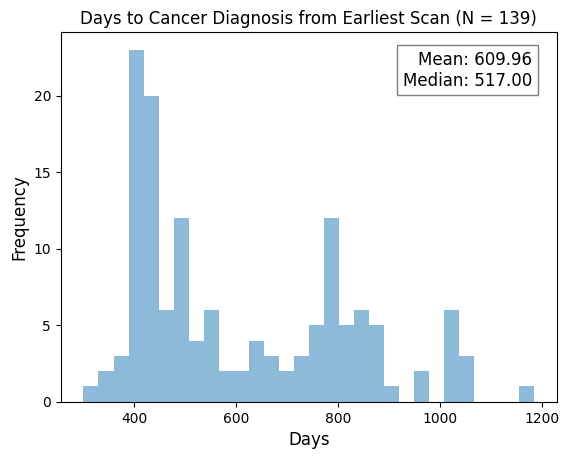

[72, 156, 60, 68, 454, 56, 349, 87, 55, 41, 68, 566, 219, 35, 183, 42, 21, 28, 277, 112, 101, 47, 251, 174, 46, 46, 506, 247, 92, 264, 84, 179, 54, 54, 54, 64, 15, 633, 60, 43, 83, 19, 39, 52, 64, 52, 56, 120, 166, 166, 326, 55, 164, 264, 349, 686, 74, 46, 387, 100, 42, 390, 390, 56, 15, 15, 15, 49, 310, 55, 325, 56, 675, 55, 20, 69, 21, 77, 124, 76, 173, 112, 36, 121, 67, 112, 66, 60, 14, 70, 145, 94, 96, 361, 49, 48, 67, 72, 88, 42, 97, 59, 123, 356, 45, 13, 116, 139, 91, 88, 54, 64, 483, 6, 123, 277, 49, 323, 75, 78, 175, 47, 114, 67, 14, 38, 58, 73, 5, 32, 221, 35, 75, 75, 15, 15, 15, 42, 99, 110, 86, 120]


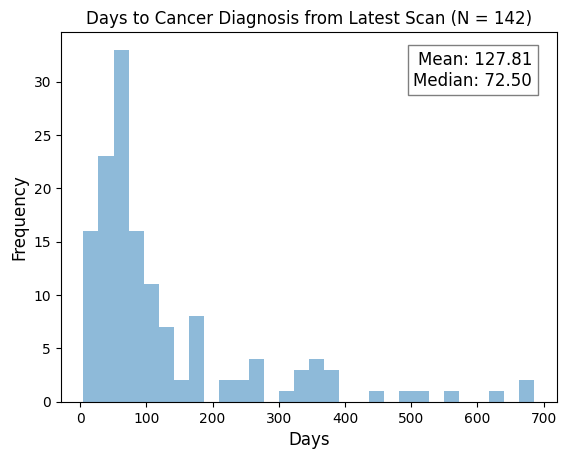

In [ ]:
plot_distribution(days_to_cancer_earliest, "Days to Cancer Diagnosis from Earliest Scan", "Days", "Frequency")
plot_distribution(days_to_cancer_latest, "Days to Cancer Diagnosis from Latest Scan", "Days", "Frequency")

## Overlaying Distributions

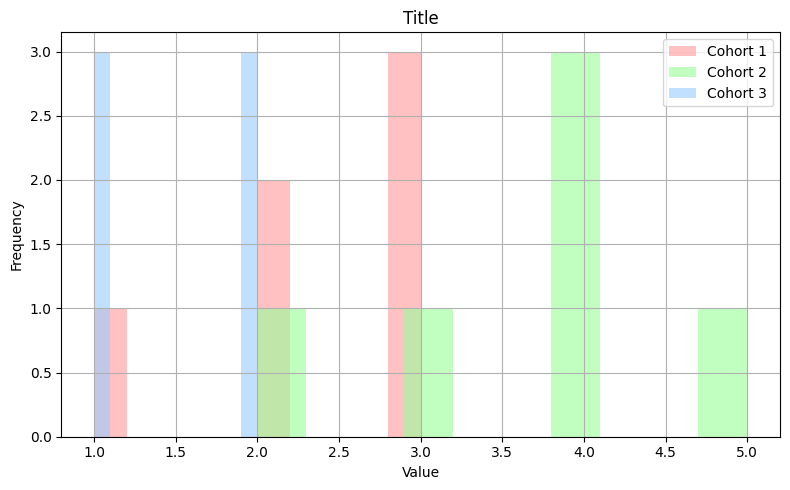

In [ ]:
data1 = [1, 2, 2, 3, 3, 3]
data2 = [2, 3, 4, 4, 4, 5]
data3 = [1, 1, 1, 2, 2, 2]

colors = ['#FF9999', '#99FF99', '#99CCFF']
alpha = 0.6

plt.figure(figsize=(8, 5))
plt.hist(data1, bins=10, alpha=alpha, color=colors[0], label='Cohort 1')
plt.hist(data2, bins=10, alpha=alpha, color=colors[1], label='Cohort 2')
plt.hist(data3, bins=10, alpha=alpha, color=colors[2], label='Cohort 3')

plt.title('Title')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Growth Over Time (Stratified by Nodule Type)

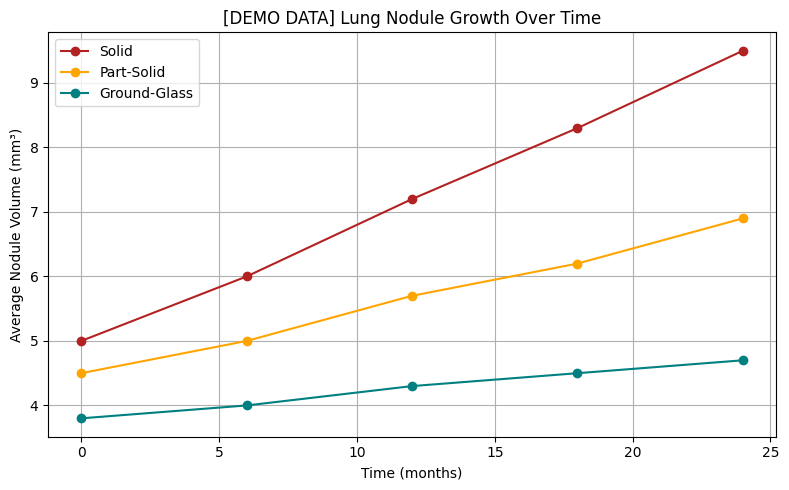

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# simulated data
time_months = np.array([0, 6, 12, 18, 24])

solid_growth = [5.0, 6.0, 7.2, 8.3, 9.5]
part_solid_growth = [4.5, 5.0, 5.7, 6.2, 6.9]
ground_glass_growth = [3.8, 4.0, 4.3, 4.5, 4.7]

df = pd.DataFrame({
    'Time (months)': time_months,
    'Solid': solid_growth,
    'Part-Solid': part_solid_growth,
    'Ground-Glass': ground_glass_growth
})

plt.figure(figsize=(8, 5))
plt.plot(df['Time (months)'], df['Solid'], label='Solid', color='firebrick', marker='o')
plt.plot(df['Time (months)'], df['Part-Solid'], label='Part-Solid', color='orange', marker='o')
plt.plot(df['Time (months)'], df['Ground-Glass'], label='Ground-Glass', color='teal', marker='o')

plt.title('[DEMO DATA] Lung Nodule Growth Over Time')
plt.xlabel('Time (months)')
plt.ylabel('Average Nodule Volume (mm³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
